The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


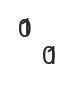

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import torch
from torch import nn
import torch.nn.functional as F
import glob
# Here you import other functions and classes
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import encode_batch, AA_KEYS, BL62_VALUES, BL62FREQ_VALUES, HLAS, BL50, BL50_VALUES
from src.models import NNAlignEFSinglePass
from src.datasets import NNAlignDatasetEFSinglePass

In [3]:
df = pd.read_csv('../data/mhc1_el_sub10k/sample_no_u.csv')

In [36]:
df200 = pd.read_csv('../data/mhc1_el_subsample/mhc1_el_200k_subsample.csv')
df200['len'] = df200['sequence'].apply(len)
df500 = pd.read_csv('../data/mhc1_el_subsample/mhc1_el_500k_subsample.csv')
df500['len'] = df500['sequence'].apply(len)

df200['flag'] = df200.apply(lambda x: any([z not in AA_KEYS for z in x['sequence']]), axis=1)
df500['flag'] = df500.apply(lambda x: any([z not in AA_KEYS for z in x['sequence']]), axis=1)

In [45]:
df200.query('pseudoseq.str.contains("X")')

,sequence,target,HLA,pseudoseq,fold,len,flag
635,IVALILSTK,1.0,HLA-A68:01,YGLIVASTKXXX,0,9,False
975,EENNSFQRL,1.0,HLA-B44:03,PAEEENQRLSPX,0,9,False
1057,KMKEALLSIGK,1.0,HLA-A03:01,MTKKMKIGKXXX,0,11,False
2105,VVNPKYEGK,1.0,HLA-A03:01,VTTVVNEGKXXX,0,9,False
2336,GANSKLTFGKG,0.0,HLA-B44:03,XYTGANGKGITL,0,11,False
...,...,...,...,...,...,...,...
195692,GRLLIQPGPRF,1.0,HLA-B27:01,KPYGRLPRFHXX,4,11,False
195894,YFDLWGRGTLVT,0.0,HLA-A24:02,XYWYFDLVTVSS,4,12,False
196815,DGQKLLFARGTML,0.0,HLA-B51:01,XFSDGQTMLKVD,4,13,False
197104,YFDLWGRGTLVT,0.0,HLA-A24:02,XYWYFDLVTVSS,4,12,False


In [212]:
df200 = df200.query('not flag').rename(columns={'pseudoseq':'context'})
df500 = df500.query('not flag').rename(columns={'pseudoseq':'context'})
from src.data_processing import PSEUDOSEQDICT
df200['pseudoseq'] = df200['HLA'].map(PSEUDOSEQDICT)
df500['pseudoseq'] = df500['HLA'].map(PSEUDOSEQDICT)
print(df500['pseudoseq'].isna().any())
df200.to_csv('../data/mhc1_el_subsample/mhc1_el_200k_subsample.csv', index=False)
df500.to_csv('../data/mhc1_el_subsample/mhc1_el_500k_subsample.csv', index=False)

In [60]:
sample = pd.concat([df200.query('HLA=="HLA-A02:01"').sample(100, random_state=13), df200.query('HLA!="HLA-A02:01"').sample(100, random_state=13)])

# testing on the fly batching

In [50]:
from torch.utils.data import SequentialSampler
dataset = NNAlignDatasetEFSinglePass(sample, 13, 9, 'BL50LO', pad_scale=-20, add_pseudo_sequence=True, indel=True)
loader = dataset.get_dataloader(50, SequentialSampler)

False


In [ ]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from src.data_processing import encode_batch, PFR_calculation, FR_lengths, pep_len_1hot, batch_insertion_deletion, batch_indel_mask
# from memory_profiler import profile
from datetime import datetime as dt


class SuperDataset(Dataset):
    def __init__(self, x=torch.empty([100, 1])):
        super(SuperDataset, self).__init__()
        self.x = x

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx]

    def get_dataset(self):
        return self

    def get_dataloader(self, batch_size, sampler, **kwargs):
        dataloader = DataLoader(self, batch_size=batch_size, sampler=sampler(self), **kwargs)
        return dataloader


class TestDataset(SuperDataset):
    """
    CLASS TO USE
    """

    # @profile
    def __init__(self, df: pd.DataFrame, max_len: int, window_size: int, encoding: str = 'onehot',
                 seq_col: str = 'sequence', target_col: str = 'target', pad_scale: float = None, indel: bool = False,
                 burnin_alphabet: str = 'ILVMFYW', feature_cols: list = ['placeholder'],
                 add_pseudo_sequence=False, pseudo_seq_col: str = 'pseudoseq', add_pfr=False, add_fr_len=False,
                 add_pep_len=False, add_z=True):
        # start = dt.now()
        super(NNAlignDatasetEFSinglePass, self).__init__()
        # Encoding stuff
        if feature_cols is None:
            feature_cols = []
        # Filter out sequences longer than max_len
        df['len'] = df[seq_col].apply(len)
        df = df.query('len<=@max_len')
        # Then, if indel is False, filter out sequences shorter than windowsize (ex: 8mers for WS=9)
        if not indel:
            df = df.query('len>=@window_size')

        matrix_dim = 20
        # query_time = dt.now()
        x = encode_batch(df[seq_col], max_len, encoding, pad_scale)
        y = torch.from_numpy(df[target_col].values).float().view(-1, 1)
        # encode_time = dt.now()
        # Creating the mask to allow selection of kmers without padding
        len_mask = torch.from_numpy(df['len'].values)
        x_mask = len_mask - window_size
        range_tensor = torch.arange(max_len - window_size + 1).unsqueeze(0).repeat(len(x), 1)
        # Mask for Kmers + padding
        x_mask = (range_tensor <= x_mask.unsqueeze(1)).float().unsqueeze(-1)
        # Expand the kmers windows for base sequence without indels
        x = x.unfold(1, window_size, 1).transpose(2, 3) \
             .reshape(len(x), max_len - window_size + 1, window_size, matrix_dim)
        # Creating indels window and mask 
        if indel:
            x_indel = batch_insertion_deletion(df[seq_col], max_len, encoding, pad_scale, window_size)
            # remove padding from indel windows
            x_indel = x_indel[:,:,:window_size, :]
            indel_mask = batch_indel_mask(len_mask, window_size)
            x = torch.cat([x, x_indel], dim=1)
            x_mask = torch.cat([x_mask, indel_mask], dim=1)

        # Creating another mask for the burn-in period+bool flag switch
        self.burn_in_mask = _get_burnin_mask_batch(df[seq_col].values, max_len, window_size, burnin_alphabet).unsqueeze(
            -1)
        self.burn_in_flag = False

        # Expand and unfold the sub kmers and the target to match the shape ; contiguous to allow for view operations
        self.x_tensor = x.flatten(2, 3).contiguous()
        self.x_mask = x_mask

   
        # kmer_time = dt.now()
        self.y = y.contiguous()
        self.x_features = torch.empty((len(x),))
        # Add extra features
        if len(feature_cols) > 0:
            # TODO: When you add more features you need to concatenate to x_pseudosequence and save it to self.x_features
            # these are NUMERICAL FEATURES like %Rank, expression, etc. of shape (N, len(feature_cols))
            # x_features = torch.from_numpy(df[feature_cols].values).float()

            self.extra_features_flag = True
        else:
            self.extra_features_flag = False

        #  TODO dictmap for 9mer look-up and see if how many duplicated and can we save memory
        #
        if add_pseudo_sequence:
            # TODO: Carlos, here you need to create the MHC feature vector and flatten it.
            #       Basically, if you have the pseudo sequence in a column called 'pseudoseq' in your dataframe,
            #       You can use my function encode_batch like
            #       Do MHC pseudosequence as a dictionary and look-up on the fly in collate_fn to map back
            #       only store dict and an ID for each datapoint
            x_pseudoseq = encode_batch(df[pseudo_seq_col], 34, encoding, pad_scale)

            # UNCOMMENT HERE WHEN YOU ARE DONE WITH THAT, check in a notebook that
            # these dimension (N, 34*20) = (N, 680) are correct (you need to FLATTEN the vector using tensor.flatten(start_dim=1)
            # then these should be working because my model forward() takes care of everything
            x_pseudoseq = x_pseudoseq.flatten(start_dim=1)
            self.x_features = x_pseudoseq
            self.extra_features_flag = True
            # ps_time = dt.now()
        if add_pfr:
            x_pfr = PFR_calculation(df[seq_col], self.x_mask, max_len, window_size)
            self.x_tensor = torch.cat([self.x_tensor, x_pfr], dim=2)
            # pfr_time = dt.now()
        if add_fr_len:
            x_fr_len = FR_lengths(self.x_mask, max_len, window_size)
            self.x_tensor = torch.cat([self.x_tensor, x_fr_len], dim=2)
            # pfr_len_time = dt.now()
        if add_pep_len:
            x_pep_len = pep_len_1hot(df[seq_col], max_len, window_size, min_length=13, max_length=21)
            self.x_tensor = torch.cat([self.x_tensor, x_pep_len], dim=2)
            # peplen_time = dt.now()

        # Saving df in case it's needed
        self.df = df
        self.len = len(x)
        self.max_len = max_len
        self.seq_col = seq_col
        self.window_size = window_size

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        """ Returns the appropriate input tensors (X, ..., y) depending on the bool flags
        A bit convoluted return, but basically 4 conditions:
            1. No burn-in, no extra features --> returns the normal x_tensor, kmers mask, target
            2. Burn-in, no extra features --> returns the normal x_tensor, burn-in mask, target
            3. No Burn-in, + extra features --> returns the normal x_tensor, kmers mask, x_features, target
            4. Burn-in, + extra features --> returns the normal x_tensor, burn-in mask, x_features, target
        :param idx:
        :return:
        """
        if self.burn_in_flag:
            if self.extra_features_flag:
                # 4
                print(
                    f'Tensor, Burn_in_mask, x_features, and y shapes: {self.x_tensor[idx].shape}, {self.burn_in_mask[idx].shape}, {self.x_features[idx].shape}, {self.y[idx].shape}')
                return self.x_tensor[idx], self.burn_in_mask[idx], self.x_features[idx], self.y[idx]
            else:
                # 2
                return self.x_tensor[idx], self.burn_in_mask[idx], self.y[idx]
        else:
            if self.extra_features_flag:
                # 3
                return self.x_tensor[idx], self.x_mask[idx], self.x_features[idx], self.y[idx]
            else:
                # 1
                return self.x_tensor[idx], self.x_mask[idx], self.y[idx]

    def burn_in(self, flag):
        self.burn_in_flag = flag


# @profile
def get_NNAlign_dataloaderEFSinglePass(df: pd.DataFrame, max_len: int, window_size: int, encoding: str = 'onehot',
                                       seq_col: str = 'Peptide', target_col: str = 'agg_label', pad_scale: float = None,
                                       indel: bool = False, burnin_alphabet: str = 'ILVMFYW', feature_cols: list = None,
                                       batch_size=64, sampler=torch.utils.data.RandomSampler, return_dataset=True,
                                       add_pseudo_sequence=False, pseudo_seq_col: str = 'pseudoseq', add_pfr=False,
                                       add_fr_len=False, add_pep_len=False):
    dataset = NNAlignDatasetEFSinglePass(df, max_len, window_size, encoding, seq_col, target_col, pad_scale, indel,
                                         burnin_alphabet, feature_cols, add_pseudo_sequence, pseudo_seq_col, add_pfr,
                                         add_fr_len, add_pep_len)
    # TODO NEW COLLATE FN ON THE FLY FOR KMERS AND MHC
    dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler(dataset))
    if return_dataset:
        return dataloader, dataset
    else:
        return dataloader


def _get_burnin_mask_batch(sequences, max_len, motif_len, alphabet='ILVMFYW'):
    return torch.stack([_get_burnin_mask(x, max_len, motif_len, alphabet) for x in sequences])


def _get_burnin_mask(seq, max_len, motif_len, alphabet='ILVMFYW'):
    mask = torch.tensor([x in alphabet for i, x in enumerate(seq) if i < len(seq) - motif_len + 1]).float()
    return F.pad(mask, (0, (max_len - motif_len + 1) - len(mask)), 'constant', 0)
